## Imports


In [3]:
import warnings
from rich import print
from datasets import load_dataset

warnings.filterwarnings("ignore")

## Dataset


In [ ]:
dataset = load_dataset("PodYapolsky/LogoDet-3K")

company2id = {
    name: idx
    for idx, name in enumerate(dataset["train"].features["company_name"].names)
}
id2company = {v: k for k, v in company2id.items()}

In [29]:
company2id["play-doh"], id2company[2186]

(2186, 'play-doh')

## Visualization


In [76]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import io


plt.rcParams["figure.figsize"] = (16, 10)  # (w, h)


def show_imgs(
    rows: list[dict],
    titles: list[str] = None,
    show_bb: bool = False,
    disable_ticks: bool = False,
):
    if titles:
        assert len(rows) == len(titles)

    count = len(rows)
    for idx in range(count):
        subplot = plt.subplot(count // 5 + 1, 5, idx + 1)

        # set title to specific id
        if titles is not None:
            subplot.set_title(titles[idx])

        row = rows[idx]
        img = row["image_path"]
        if isinstance(img, Image.Image):
            pass
        elif isinstance(img, dict):
            img = Image.open(io.BytesIO(img["bytes"]))
        else:
            raise TypeError("img is of inappropriate type")

        xmin, ymin, xmax, ymax = row["bbox"]

        # draw bounding vox
        if show_bb:
            draw = ImageDraw.Draw(img)
            draw.rectangle([(xmin, ymin), (xmax, ymax)], outline="green", width=3)

        # cmap = "gray" if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(np.asarray(img, dtype=np.float32) / 255, cmap=None)

        if disable_ticks:
            plt.xticks([]), plt.yticks([])

    plt.show()

{
    'image_path': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=387x520 at 0x75284012B380>,
    'industry_name': 'Clothes',
    'company_name': 2020,
    'bbox': [22, 68, 366, 448]
}

nicole lee-1

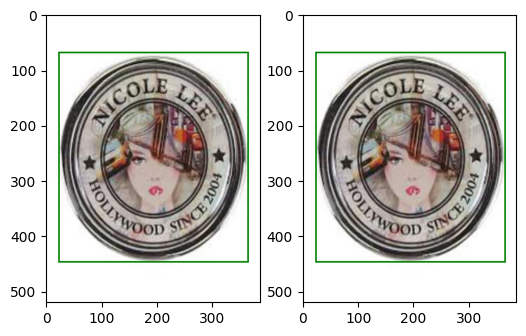

In [78]:
row = dataset["train"][0]
print(row)
print(id2company[row["company_name"]])

show_imgs([row, row], show_bb=True)

## Play Doh Example

Обозначим компанию Play Doh - искомой


In [51]:
play_dohs = dataset.filter(lambda row: row["company_name"] == company2id["play-doh"])

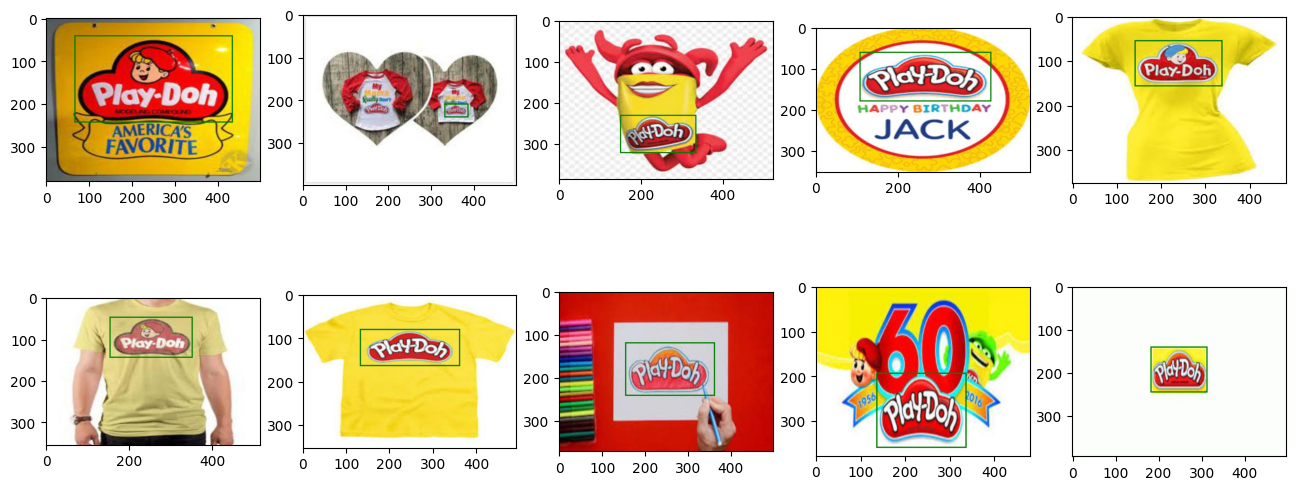

In [82]:
play_dohs_train_10 = play_dohs["train"].to_list()[:10]
show_imgs(play_dohs_train_10, show_bb=True)

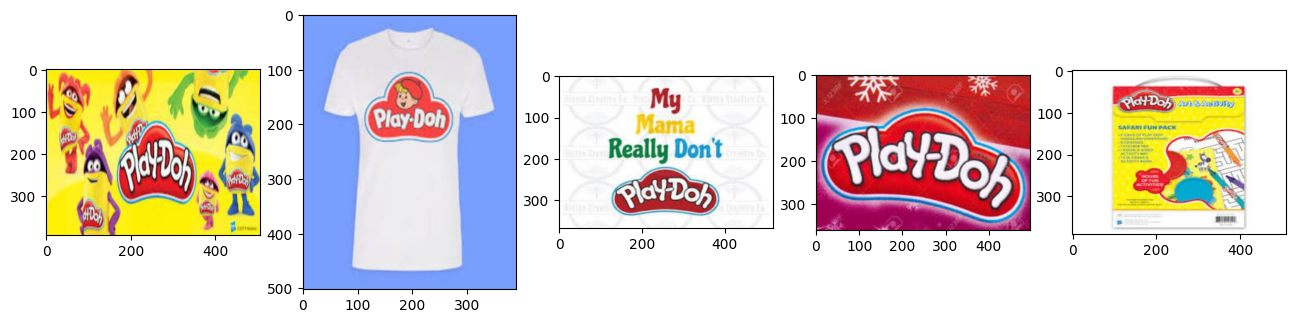

In [84]:
play_dohs_test_5 = play_dohs["test"].to_list()[:5]
show_imgs(play_dohs_test_5, show_bb=False)

{
    'image_path': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=517x368 at 0x75234826FAA0>,
    'industry_name': 'Leisure',
    'company_name': 2186,
    'bbox': [111, 216, 398, 345]
}

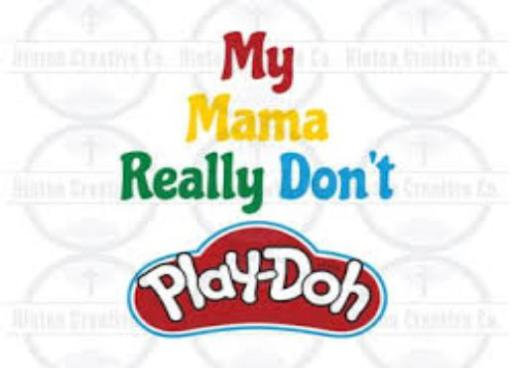

In [97]:
test_row = play_dohs["test"][2]
print(test_row)

test_row['image_path']

## YOLO


In [ ]:
import torch

# Model
model = torch.hub.load("ultralytics/yolov5", "yolov5s")  # or yolov5n - yolov5x6, custom

# Images
img = test_row["image_path"]  # or file, Path, PIL, OpenCV, numpy, list

# Inference
results = model(img)

# Results
results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

Using cache found in /home/solan/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-2-3 Python-3.12.8 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
image 1/1: 368x517 (no detections)
Speed: 16.0ms pre-process, 88.9ms inference, 1.0ms NMS per image at shape (1, 3, 480, 640)


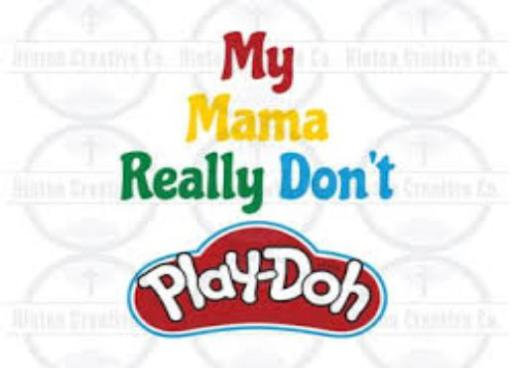

In [96]:
results.show()

TRY TRAINING YOLO


## SIFT


In [ ]:
import cv2


def process_image_SIFT(large_image_path, template_image_path):
    sift = cv2.SIFT_create()
    large_image = cv2.imread(large_image_path, 0)
    template = cv2.imread(template_image_path, 0)
    kp1, des1 = sift.detectAndCompute(large_image, None)
    kp2, des2 = sift.detectAndCompute(template, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append([m])

    result_image = cv2.drawMatchesKnn(
        large_image,
        kp1,
        template,
        kp2,
        good,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    return result_image



In [ ]:
sift = cv2.SIFT.create()

